In [2]:
# https://towardsdatascience.com/tf-idf-for-document-ranking-from-scratch-in-python-on-real-world-dataset-796d339a4089
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import numpy as np
from num2words import num2words
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import re
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split

import spacy
import en_core_web_sm


# Tfidf transformer 
from sklearn.feature_extraction.text import TfidfVectorizer

#https://www.nltk.org/howto/stem.html
from nltk.stem.porter import *


In [3]:
dataset = pd.read_csv('src/train.csv')
dataset.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
pourcentage_valeur_manquante = 100*dataset.isnull().sum()/dataset.shape[0]
print(pourcentage_valeur_manquante)

id           0.000000
keyword      0.801261
location    33.272035
text         0.000000
target       0.000000
dtype: float64


In [5]:
dataset = dataset.drop(columns=['id', 'location'])

In [6]:
dataset = dataset.dropna()
dataset['keyword'] = [ x.replace('%20', ' ') for x in dataset['keyword']]
len(dataset['keyword'].unique())

221

In [7]:
len(dataset)

7552

In [8]:
# https://medium.com/@yashj302/stopwords-nlp-python-4aa57dc492af
nlp = en_core_web_sm.load()

stopwords = nlp.Defaults.stop_words
print(stopwords)

def cleanStopWorld(text):
    cleanedtext = []
    for item in nlp(text):
        if not item.is_stop:
            cleanedtext.append(item.text)
    return ' '.join(cleanedtext)
    

{'give', 'per', 'this', 'after', 'something', 'who', 'if', 'already', 'under', 'hereupon', 'might', 'where', 'before', 'noone', 'until', 'moreover', 'i', 'yours', 'next', 'no', 'whom', 're', 'seems', 'almost', 'is', 'eleven', 'their', 'regarding', 'be', 'among', 'them', 'towards', 'hereby', 'but', 'seemed', 'am', 'than', 'several', 'must', 'whither', 'will', 'serious', 'wherever', 'all', 'out', 'together', 'everything', 'others', 'yourself', 'thereupon', 'above', 'so', 'doing', 'of', 'just', 'its', 'toward', "'re", 'however', 'upon', 'few', 'everywhere', 'indeed', 'anywhere', 'thus', 'part', 'my', 'ever', 'you', 'top', 'two', 'whose', 'most', 'become', 'alone', 'see', 'formerly', '’s', 'himself', 'same', 'an', 'when', '‘d', 'sixty', 'four', 'through', 'hence', 'there', 'three', 'behind', 'unless', 'name', 'mostly', 'hereafter', 'otherwise', 'would', 'may', 'was', 'eight', '’ll', 'each', 'again', 'have', 'she', 'via', 'without', 'one', 'often', 'hers', 'below', 'meanwhile', 'became', 'p

In [9]:
def eraseSingleChar(words):
    new_text = ""
    for w in list(words.split(" ")):
        if len(w) > 1:
            new_text = new_text + " " + w
    return new_text

In [10]:
# convert exemple "Player", "Playing" to "play"
stemmer = PorterStemmer()

def stemConverter(sentence):
    new_text = ""
    for w in list(sentence.split(" ")):
        new_text = new_text + " " + stemmer.stem(w)
    return new_text

In [11]:
# from numbers to string 
def convert_num_to_words(utterance):
      utterance = ' '.join([num2words.num2words(i) if i.isdigit() else i for i in utterance.split()])
      return utterance

In [12]:
for column in ['keyword', 'text']:
    dataset[column] = [ np.char.lower(x) for x in dataset[column]]
    dataset[column] = [ str(x) for x in dataset[column] ] # str check for "numbers"
    dataset[column] = [ x.replace("\\/", "/").encode().decode('utf-8') for x in dataset[column] ] # magic line for error byte string
    dataset[column] = [ re.sub(r'http\S+', '', x) for x in dataset[column] ] # delete http 
    dataset[column] = [ re.sub('[^A-Za-z0-9 ]+', '', x) for x in dataset[column] ] # delete @#$€...
    #
    dataset[column] = [ cleanStopWorld(x) for x in dataset[column] ] # erase stop world 
    #
    dataset[column] = [ eraseSingleChar(x) for x in dataset[column] ] # erase isolate 2 chars
    #
    dataset[column] = [ stemConverter(x) for x in dataset[column] ] # convert to stem words

In [13]:
dataset = dataset.dropna()

In [14]:
dataset['text'] = dataset['keyword'].astype(str) + dataset['text'].astype(str)

In [15]:
dataset

,keyword,text,target
31,ablaz,ablaz bbcmtd wholesal market ablaz,1
32,ablaz,ablaz tri bring heavi metal rt,0
33,ablaz,ablaz africanbaz break newsnigeria flag set...,1
34,ablaz,ablaz cri set ablaz,0
35,ablaz,ablaz plu look sky night ablaz,0
...,...,...,...
7578,wreck,wreck jtruff23 cameronhack wreck,0
7579,wreck,wreck day work ve pretti wreck hahaha shout...,0
7580,wreck,wreck fx forex trade cramer iger word wreck...,0
7581,wreck,wreck enginesh great atmospher british lion...,0


In [16]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=1000, oov_token="out_of_vocab") # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.text)
dataset["text_encoded"] = tokenizer.texts_to_sequences(dataset.text)

In [17]:
dataset

,keyword,text,target,text_encoded
31,ablaz,ablaz bbcmtd wholesal market ablaz,1,"[213, 1, 1, 310, 213]"
32,ablaz,ablaz tri bring heavi metal rt,0,"[213, 220, 453, 697, 962, 90]"
33,ablaz,ablaz africanbaz break newsnigeria flag set...,1,"[213, 1, 270, 1, 527, 221, 213, 910]"
34,ablaz,ablaz cri set ablaz,0,"[213, 624, 221, 213]"
35,ablaz,ablaz plu look sky night ablaz,0,"[213, 1, 48, 724, 285, 213]"
...,...,...,...,...
7578,wreck,wreck jtruff23 cameronhack wreck,0,"[30, 1, 1, 30]"
7579,wreck,wreck day work ve pretti wreck hahaha shout...,0,"[30, 56, 98, 119, 588, 30, 1, 1, 58]"
7580,wreck,wreck fx forex trade cramer iger word wreck...,0,"[30, 1, 1, 1, 1, 1, 345, 30, 853, 364]"
7581,wreck,wreck enginesh great atmospher british lion...,0,"[30, 1, 233, 1, 756, 1, 1, 314, 383, 30]"


In [18]:
reviews_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset.text_encoded, padding="post")

In [19]:
# Train Test Split
xtrain, xval, ytrain, yval = train_test_split(reviews_pad,dataset.target, test_size=0.3)

In [20]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))

train_batch = train.shuffle(train.cardinality()).batch(64)
val_batch = val.shuffle(val.cardinality()).batch(64)

2022-09-16 16:51:15.075813: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [21]:
review = []
 # Some batch
for review, star in train_batch.take(1):
    # print(review, star)
    review = review

## Modeling

In [22]:
vocab_size = tokenizer.num_words
model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size+1, 8, input_shape=(review.shape[1],),name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  # Couche de sortie avec le nombre de neurones en sortie égale au nombre de classe avec fonction softmax
                  tf.keras.layers.Dense(1, activation="linear")
])

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 23, 8)             8008      
                                                                 
 global_average_pooling1d (G  (None, 8)                0         
 lobalAveragePooling1D)                                          
                                                                 
 dense (Dense)               (None, 16)                144       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 8,169
Trainable params: 8,169
Non-trainable params: 0
_________________________________________________________________


In [24]:
optimizer= tf.keras.optimizers.Adam()

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [25]:
history = model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
83/83 [==============================] - 1s 4ms/step - loss: 0.3019 - mean_absolute_error: 0.4559 - val_loss: 0.2467 - val_mean_absolute_error: 0.4868
Epoch 2/20
83/83 [==============================] - 0s 3ms/step - loss: 0.2342 - mean_absolute_error: 0.4765 - val_loss: 0.2296 - val_mean_absolute_error: 0.4697
Epoch 3/20
83/83 [==============================] - 0s 2ms/step - loss: 0.2052 - mean_absolute_error: 0.4404 - val_loss: 0.1887 - val_mean_absolute_error: 0.4162
Epoch 4/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1588 - mean_absolute_error: 0.3576 - val_loss: 0.1600 - val_mean_absolute_error: 0.3374
Epoch 5/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1401 - mean_absolute_error: 0.3071 - val_loss: 0.1549 - val_mean_absolute_error: 0.3204
Epoch 6/20
83/83 [==============================] - 0s 2ms/step - loss: 0.1334 - mean_absolute_error: 0.2932 - val_loss: 0.1539 - val_mean_absolute_error: 0.3170
Epoch 7/20
83/83 [==========

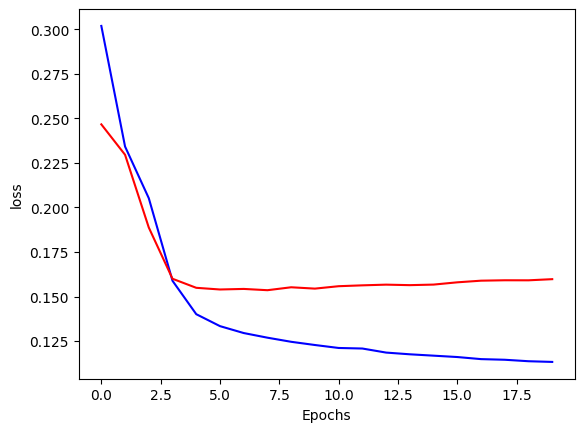

In [26]:
# Visualization of the training process on the loss function 
plt.plot(history.history["loss"], color="b")
plt.plot(history.history["val_loss"], color="r")
plt.ylabel("loss")
plt.xlabel("Epochs")
plt.show()

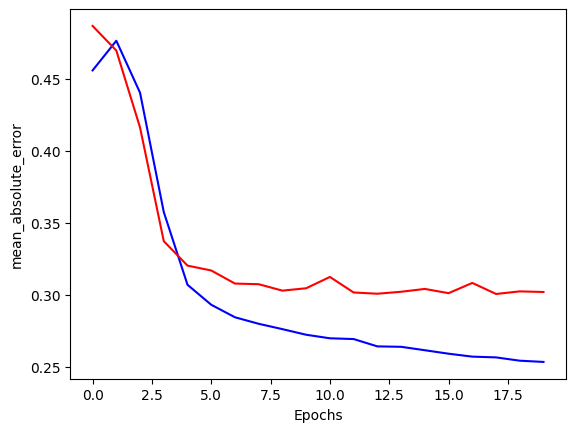

In [27]:
# Visualization of accuracy training 
plt.plot(history.history["mean_absolute_error"], color="b")
plt.plot(history.history["val_mean_absolute_error"], color="r")
plt.ylabel("mean_absolute_error")
plt.xlabel("Epochs")
plt.show()

In [28]:
#dataset_with_token.to_csv(r'src/dataset_tokenized.csv', index=False)